In [21]:
#| default_exp obj_setup

In [1]:
#| hide
from nbdev.showdoc import *
import nbdev 
from nbdev import nbdev_export

## imports

In [2]:
#| export 
import warnings
warnings.filterwarnings("ignore")

import os
import json
import requests
import logging

from bs4 import BeautifulSoup
import re
import tarfile
from owslib.wfs import WebFeatureService
from requests import Request

import geopandas as gpd
import shapely
from shapely import geometry
from shapely.geometry import Point
from shapely.geometry import Polygon

import numpy as np
import pandas as pd


import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt
import matplotlib as mpl


import s3fs
# to get and use geojson datacube catalog
import logging

# for timing data access
import time
import numpy as np
import pyproj
import s3fs as s3
# for datacube xarra
from pyproj import Transformer

# for plotting time series
from tqdm import tqdm
import re
import ipyleaflet as ipyl
import ipywidgets as ipyw
from ipywidgets import HTML


logging.basicConfig(level=logging.ERROR)

In [3]:
#| export
from ITS_LIVE_TOOL import datacube_tools, interactive

## Defining classes

In [4]:
#| export
def point_to_gdf(point_ls):
    '''
    creates a geodataframe from a given point

    input: list of [x,y] coords
    output: geopandas gdf of point, in epsg:4326
    '''
        
    d = {'x': point_ls[0],
         'y': point_ls[1]}
    df = pd.DataFrame(d, index=[0])
    gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.x, df.y, crs='EPSG:4326'))
    return gdf

def swap_time_dim(ds):
    '''this function does a few main things:
    1. creates a numeric time dimension (off of mid-date) and swaps that for mid-date to be a dim
    2. creates a temporal baseline variable (img_separation)
    3. creates a variable called obs id that is meant to be a unique identifier for each time step since the mid-date indexer is non unique
    4. removes empty time steps 
    '''
    #add a numeric time dimensions
    ds['time_numeric'] = ds.mid_date.dt.year + ds.mid_date.dt.dayofyear / 365
    ds = ds.swap_dims({'mid_date':'time_numeric'})

    #add numeric versions of img date 1, 2
    ds['img1_numeric'] = ds.acquisition_date_img1.dt.year + ds.acquisition_date_img1.dt.dayofyear / 365
    ds['img2_numeric'] = ds.acquisition_date_img2.dt.year + ds.acquisition_date_img2.dt.dayofyear / 365

    #add temp baseline as a coordinate
    ds = ds.assign_coords({'img_separation': ds.img_separation})

    #sort by time dimension
    ds = ds.sortby('time_numeric')
    #add unique identifier
    ds['obs_id'] = (('time_numeric'), range(len(ds['time_numeric'])))
    ds = ds.assign_coords({'obs_id':ds['obs_id']})
    # drop empty time steps
    ds = ds.dropna(how='all', dim='time_numeric', subset='v')
    return ds

#def add_unique_ids(ds):

#    ds = ds.sortby('time_numeric')
#    ds['obs_id'] = (('time_numeric'), range(len(ds['time_numeric'])))
#    ds = ds.assign_coords({'obs_id':ds['obs_id']})
#    return ds
    
def drop_empty_timesteps(ds):
    ds = ds.dropna(how='all', dim='time_numeric', subset='v')
    return ds

In [5]:
#| export
class Glacier_Centerline():
    '''class to hold all data associated with a centerline'''
    def __init__(self, name, rgi_id):
        self.name = name
        self.rgi_id = rgi_id
        self.rgi_region = rgi_id.split('-')[1].split('.')[0]
        self._centerline_path = self._download_centerlines()
        self.centerlines, self.main_centerline, self.utm_zone = self._add_centerlines()
        #self.padded_centerline_subcube = self._extract_subcube_along_padded_centerline()

    def _download_centerlines(self, dest_folder = os.getcwd()):
        '''function to download oggm centerlines by rgi region. 
        destination folder is a 'centerlines dir in the root folder
        ''' 
        os.makedirs(dest_folder.split('nbs')[0]+'centerlines', exist_ok=True)
        dest_folder = dest_folder.split('nbs')[0]+'centerlines/'
    
        #this first part of htis function is scraping the urls for OGGM centerlines for each RGI region from the summary page
        # and organizing them into a dict 
        # hardcoded -- this is the link to OGGM centerlines separated into rgi regions -- each is compressed as tar.gz
        orig_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L1-L2_files/centerlines/RGI62/b_010/L2/summary/'
        response = requests.get(orig_url)
        link_header = orig_url.split('~oggm')[0][:-1] #isolate just the beginning
            
        #print('link header :', link_header)
        #link_header = 'https://cluster.klima.uni-bremen.de'
        soup = BeautifulSoup(response.text, 'html.parser')
        header = soup.find('h1') #this points to the summary page containing links for all regions 
        gen_link = str(header).split(' ')[2].split('<')[0]
        data_url_gen = link_header + gen_link + '/' #this is the full url to the summary paeg
        links = soup.find_all('a') #find all the links contained in page
        
        smoothed_flag = 'smoothed' # want only 'centerlines', not smoothed centerlines -- can change this
        region_ls, region_url_ls = [],[]
        
        for link in range(len(links)): #this loop creates a dict where each key is an rgi region and each value is the url to that regions oggm centerlines
            if links[link].attrs['href'].startswith('centerlines'):
        
                if smoothed_flag not in links[link].attrs['href']:
                    region = links[link]['href'].split('_')[1].split('.')[0]
                    region_url = data_url_gen+ links[link]['href']
                    region_ls.append(region)
                    region_url_ls.append(region_url)
                    
                else:
                    pass
        
        region_url_dict = dict(zip(region_ls, region_url_ls))
        rgi_region_code = self.rgi_region
    
        region_centerline_url = region_url_dict[rgi_region_code]
        #print('url for specified region : ', region_centerline_url)
        
        #download_extract(region_centerline_url, dest_folder = dest_folder)
    
        #the second part of this function is reading the specified url, and downloading + extracting the file to a specified location
        
        #help from https://stackoverflow.com/questions/56950987/download-file-from-url-and-save-it-in-a-folder-python
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)
    
        filename = region_centerline_url.split('/')[-1].replace(" ", "_")
        file_path = os.path.join(dest_folder, filename)
        #print(file_path)
    
        r = requests.get(region_centerline_url, stream=True)
        if r.ok:
            #print('saving to: ', os.path.abspath(file_path))
            with open(file_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024*8):
                    if chunk:
                        f.write(chunk)
                        f.flush()
                        os.fsync(f.fileno())
                    else:
                        print('donwload failed')
    
        
        file = tarfile.open(file_path)
        file.extractall(dest_folder)
    
        #return the path to the shp file
        a = file_path.split('tar.gz')[0] + 'shp'
        #print(a)
        return a

    def _add_centerlines(self):
        '''function to add gpd.geodataframe of oggm centerlines as an attribute to glacier centerline object
        '''
        gpdf = gpd.read_file(self._centerline_path)

        gpdf = gpdf.loc[gpdf['RGIID'] == self.rgi_id]
        utm = str(gpdf.estimate_utm_crs())
        
        gpdf_main = gpdf.loc[gpdf['MAIN'] == 1].to_crs(utm)
        gpdf_all = gpdf.to_crs(utm)
        return gpdf_all, gpdf_main, utm

    #def _extract_subcube_along_padded_centerline(self, pad=200):
    # removing because this pulls the subucbe around a point, not an entire centerline. need to replace the subcube for a larger object but the fix for glacier_point should be done first
    #    cl = self.centerline_main.to_crs(self.utm_crs)
    #    line = shapely.geometry.LineString(cl.get_coordinates().loc[:,['x','y']].values)
    #    PAD = pad #meters
    #    line_buf = gpd.GeoSeries([line], crs=self.utm_crs).buffer(PAD, cap_style=2)
    #    padded_cl_gdf = gpd.GeoDataFrame({'id':self.label,
    #                              'padding':120}, index=[0], geometry=line_buf)
    #    glacier_subcube_cl = self.datacube_sub.rio.clip(padded_cl_gdf.geometry, padded_cl_gdf.crs)
    #    return glacier_subcube_cl

    def sample_n_points(self, n ):
        '''function to select n equally spaced points along a glacier centerline. This is how glacier_centerline object can wrap glacier_point objects
        '''
    #help from https://stackoverflow.com/questions/62990029/how-to-get-equally-spaced-points-on-a-line-in-shapely

        distances = np.linspace(0, self.main_centerline.length*0.90, n)
        points = [self.main_centerline.interpolate(distance) for distance in distances]
        multipoint = unary_union(points)
        labels = [f'point {i}' for i in range(n)]
        coords = [(p.x, p.y) for p in multipoint.geoms]
        xs = [coords[i][0] for i in range(len(coords))]
        ys = [coords[i][1] for i in range(len(coords))]
        df = pd.DataFrame({'label':labels,
                       'x':xs,
                       'y':ys})
        gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df['x'], df['y'])).set_crs(self.utm_zone)
        return gdf
        
        

In [6]:
#| export
class Glacier():
    '''class to hold all data associated with individual glacier
    inputs: name (str), rgi_id (str), and how the object was created (either from the map widget or manually)

    NOTE: now a 'creation_flag' must be passed. this specifies if the object was created manually or 
    directly from an interaction with the widget. If created from the widget, it takes the rgi outline
    from the clicked data, if created manually it accesses via request
    
    '''
    def __init__(self, name, rgi_id, utm_crs, creation_type, rgi_outline_from_widget='None', itslive_url='None'):

        self.name = name
        self.rgi_id = rgi_id
        self.creation_type = creation_type
        self._rgi_outline_from_widget = rgi_outline_from_widget
        self._rgi_region = rgi_id.split('-')[1].split('.')[0]
        self._outline = self._download_rgi()
        self.utm_zone = utm_crs #fix to access utm zone from rgi outline
        self.outline_prj = self._outline.to_crs(self.utm_zone)
        self.itslive_url = itslive_url #this for passing to inversion script
        #self.utm_zone = str(self.outline.estimate_utm_crs())
        
    def _download_rgi(self):
        '''function to download RGI data for a specified region
        '''
       
        if self.creation_type == 'widget':

            data_glacier = self._rgi_outline_from_widget
                  
            return data_glacier

        elif self.creation_type == 'manual':

            region = self._rgi_region
        
            rgi_region_dict = {'01': 'GLIMS:RGI_Alaska', '02':  'GLIMS:RGI_WesternCanadaUS', '03':  'GLIMS:RGI_ArcticCanadaNorth',
                           '04': 'GLIMS:RGI_ArcticCanadaSouth', '05':  'GLIMS:RGI_GreenlandPeriphery', '06': 'GLIMS:RGI_Iceland',
                           '07':  'GLIMS:RGI_Svalbard', '08':  'GLIMS:RGI_Scandinavia', '09': 'GLIMS:RGI_RussianArctic', 
                           '10': 'GLIMS:RGI_NorthAsia', '11':  'GLIMS:RGI_CentralEurope', '12':  'GLIMS:RGI_CaucasusMiddleEast',
                           '13':   'GLIMS:RGI_CentralAsia', '14': 'GLIMS:RGI_SouthAsiaWest', '15': 'GLIMS:RGI_SouthAsiaEast',
                           '16':  'GLIMS:RGI_LowLatitudes', '17': 'GLIMS:RGI_SouthernAndes', '18': 'GLIMS:RGI_NewZealand',
                           '19':  'GLIMS:RGI_AntarcticSubantarctic'}
        
            rgi_region_name = rgi_region_dict[region]
        
            rgi_url = "https://www.glims.org/geoserver/ows?service=wms&version=1.3.0&request=GetCapabilities"
           
            wfs = WebFeatureService(url=rgi_url,  version = "2.0.0")
            
            layers = list(wfs.contents)
        
            layer = [layers[i] for i in range(len(layers)) if layers[i] == rgi_region_name][0]
            response = wfs.getfeature(typename = layer, outputFormat='SHAPE-ZIP')
            data = gpd.read_file(response)
        
            data_glacier = data.loc[data['RGIID'] == self.rgi_id]
            
            return data_glacier

In [7]:
#| export 

class Glacier_Point():
    '''class to hold all data associated with individual points on a glacier
    inputs: name (str), label of point, rgi id (str), point coordinates in latlon (list)
    '''
    def __init__(self, name, label, rgi_id, point_coords_latlon):

        self.name = name
        self.label = label
        self.rgi_id = rgi_id
        self.var_ls = ['v','vy','vx','v_error','mapping','satellite_img1','satellite_img2','acquisition_date_img1', 'acquisition_date_img2']
        #self.utm_crs = utm_crs
        #self.glacier_gridded_data = glacier_obj.utm_gridded_data
        #self.glacier_centerline = glacier_obj.centerline_main
        self.point_latlon = point_coords_latlon
        self.point_gdf = self.point_to_gdf()
        #self.utm_crs = str(self.point_gdf.estimate_utm_crs())
        #self.datacube_point = drop_empty_timesteps(self._add_image_pair_point())
        self.datacube_sub = drop_empty_timesteps(self._add_image_pair_subcube())
        self.utm_crs = str(self.datacube_sub.rio.crs)
        #self.padded_centerline_subcube = self._extract_subcube_along_padded_centerline()
        self.cube_around_point = drop_empty_timesteps(self._extract_3x3_cube_around_point())

    def _set_var_ls(self):
        '''this is a function that allows a user to pass their own list of variables to be pulled for hte itslive time series
        if no alternative list is passed then the variables listed below are pulled.
        would be good to add some sort of message with variable options, syntax requirements etc
        '''
        if self._non_default_var_ls == 'no':
            
            var_ls == ['v','vy','vx','v_error','mapping','satellite_img1','satellite_img2','acquisition_date_img1', 'acquisition_date_img2']
        
        else: 
            var_ls = input('Type the variables you would like to access here')

            return var_ls
            
    def point_to_gdf(self):
        '''This method takes the point_latlon attribute of a glacier_point class object. 
        It returns a geopandas data frame of the specified point
        '''
        
        d = {'x': self.point_latlon[0],
             'y':self.point_latlon[1]}
        df = pd.DataFrame(d, index=[0])
        gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.x, df.y, crs='EPSG:4326'))
        return gdf
            
    def _add_image_pair_point(self):
        ''' uses ITS_LIVE datacube tools to access the itslive image pair time series for a given point
        does some preliminary formatting of xarray object returned by datacubetools.get_timeseries_at_point()
        '''

        dc = datacube_tools.DATACUBETOOLS()
        var_ls = self.var_ls 
        dc_point_full = dc.get_timeseries_at_point(self.point_latlon, point_epsg_str = '4326', variables = self.var_ls)
        dc_point = dc_point_full[1]
        crs = f"EPSG:{dc_point.mapping.attrs['spatial_epsg']}"
        dc_point = dc_point.rio.write_crs(crs)
        #dc_point = dc_point.rio.write_nodata(np.nan)
        dc_point = dc_point.dropna(how='any', dim='mid_date')

    
        dc_point['acquisition_date_img1'] = (('mid_date'), pd.to_datetime(dc_point.acquisition_date_img1))
        dc_point['acquisition_date_img2'] = (('mid_date'), pd.to_datetime(dc_point.acquisition_date_img2))
    
        dc_point['img_separation'] = -1*((dc_point.acquisition_date_img1 - dc_point.acquisition_date_img2).astype('timedelta64[D]') / np.timedelta64(1,'D'))

        dc_point = swap_time_dim(dc_point)
        
        return dc_point


    def _add_image_pair_subcube(self):
        '''same as _add_image_pair_subcube() but uses the datacubetools method get_subcube_around_point() 
        '''

        dc = datacube_tools.DATACUBETOOLS()
        var_ls = self.var_ls
        dc_full_sub = dc.get_subcube_around_point(self.point_latlon, point_epsg_str = '4326', variables=var_ls)
        crs = f"EPSG:{dc_full_sub[0].mapping.attrs['spatial_epsg']}"
        dc_sub = dc_full_sub[1]
        dc_sub = dc_sub.rio.write_crs(crs)
        dc_sub = dc_sub.dropna(how='all', dim='mid_date')
        dc_sub['acquisition_date_img1'] = (('mid_date'), pd.to_datetime(dc_sub.acquisition_date_img1))
        dc_sub['acquisition_date_img2'] = (('mid_date'), pd.to_datetime(dc_sub.acquisition_date_img2))
    
        dc_sub['img_separation'] = -1*((dc_sub.acquisition_date_img1 - dc_sub.acquisition_date_img2).astype('timedelta64[D]') / np.timedelta64(1,'D'))

        dc_sub = dc_sub.dropna(how='all', dim='mid_date', subset='v')
     
        dc_sub = swap_time_dim(dc_sub)
        
        return dc_sub
        
    def _extract_3x3_cube_around_point(self):
    
        padded_point = gpd.GeoDataFrame({'id':self.label}, 
                                index=[0],
                                geometry = self.point_gdf.to_crs(self.utm_crs).buffer(distance=200))
        dc = self.datacube_sub.rio.clip(padded_point.geometry, padded_point.crs)

        return dc

   

### Selecting data

In [8]:
#| hide 

data_map = interactive.Widget()

In [9]:
#| hide 

data_map.display()

## Creating objects of `Glacier`, `Glacier_Centerline`, `Glacier_Point` classes

### Create directly from widget

In [10]:
#| export
def create_glacier_from_click(w_obj, i):
    '''this function takes clicked information (from a single click, not all clicked points) and returns a `Glacier` type object
    '''
    if len(w_obj.added_glaciers) > 0:
        name = w_obj.added_glaciers[i]['NAME'].iloc[0]
        rgi_id =  w_obj.added_glaciers[i]['RGIID'].iloc[0]
        utm_crs = str(w_obj.added_glaciers[i].estimate_utm_crs())
        rgi_gpdf = w_obj.added_glaciers[i]
        itslive_url = w_obj.urls[i]
        glacier = Glacier(name, rgi_id, utm_crs, 'widget', rgi_gpdf, itslive_url)
        
        return glacier

    else:
        print('No selection made')

In [11]:
#| export
def create_glacier_point_from_click(w_obj, i, label):
    #var_ls = ['v','vy','vx','v_error','mapping','satellite_img1','satellite_img2','acquisition_date_img1', 'acquisition_date_img2']

    if len(w_obj.added_glaciers) > 0:

        glacier_pt = Glacier_Point(w_obj.added_glaciers[i]['NAME'], label,  w_obj.added_glaciers[i]['RGIID'].iloc[0], [w_obj.added_coords[i][1], w_obj.added_coords[i][0]])
        #note , need to add test for cases where itslive is in a different crs than gpd.estimate_utm_crs() expects
        return glacier_pt
    else:
        print('No selection made')

In [12]:
#| export 
def create_glacier_centerline_from_click(w_obj, i):

    if len(w_obj.added_glaciers) > 0:
        glacier_cl = Glacier_Centerline(w_obj.added_glaciers[i]['NAME'], w_obj.added_glaciers[i]['RGIID'].iloc[0])
    
        return glacier_cl

    else: 
        print('No selection made')

In [13]:
#| export
def create_multiple_glacier_objs(w_obj):
    glacier_ls = []
    
    if len(w_obj.added_glaciers) > 0:

        for i in range(len(w_obj.added_glaciers)):
        
            glacier = create_glacier_from_click(w_obj, i)
            glacier_ls.append(glacier)
    
        return glacier_ls
        #glacier0, glacier1 = glacier_ls[0], glacier_ls[1]
    else:
        print('No selection made')

In [14]:
#| export

def create_multiple_glacier_point_objs(w_obj):

    if len(w_obj.added_glaciers) > 0:
        glacier_pt_ls = []
    
        label_ls = ['point 0','point 1']
        
        for i in range(len(w_obj.added_glaciers)):
        
            glacier_pt = create_glacier_point_from_click(w_obj,i, label_ls[i])
            glacier_pt_ls.append(glacier_pt)
    
        return glacier_pt_ls
        
    else:
        print('No selection made')
   # glacier_pt0, glacier_pt1 = glacier_pt_ls[0], glacier_pt_ls[1]

In [15]:
#| export

def create_multiple_glacier_centerline_objs(w_obj):
    if len(w_obj.added_glaciers) > 0:
        
        glacier_centerline_ls = []
    
        for i in range(len(w_obj.added_glaciers)):
    
            glacier_centerline = create_glacier_centerline_from_click(w_obj, i)
            glacier_centerline_ls.append(glacier_centerline)
    
        return glacier_centerline_ls

    else:
        print('No selection made')

In [16]:
#| hide 

glacier = create_glacier_from_click(data_map, 0)

In [17]:
#| hide 

glacier_pt = create_glacier_point_from_click(data_map, 0, 'test label')

original xy [-139.44396972656253, 60.394310536172114] 4326 maps to datacube (-3267683.9170393096, 253957.24542284355) EPSG:3413
subset and load at   4.24 seconds


In [18]:
glacier_pt.cube_around_point

<xarray.Dataset>
Dimensions:                (time_numeric: 1377, x: 3, y: 3)
Coordinates:
    mid_date               (time_numeric) datetime64[ns] 1985-10-27T19:53:34....
  * x                      (x) float64 -3.268e+06 -3.268e+06 -3.268e+06
  * y                      (y) float64 2.541e+05 2.54e+05 2.539e+05
    img_separation         (time_numeric) float64 16.0 17.0 16.0 ... 40.0 24.0
  * time_numeric           (time_numeric) float64 1.986e+03 ... 2.023e+03
    obs_id                 (time_numeric) int64 0 4 7 8 ... 2586 2589 2590 2591
    mapping                int64 0
Data variables:
    v                      (time_numeric, y, x) float32 325.0 nan ... 184.0
    vy                     (time_numeric, y, x) float32 -314.0 nan ... 151.0
    vx                     (time_numeric, y, x) float32 87.0 nan ... 71.0 105.0
    v_error                (time_numeric, y, x) float32 209.0 nan ... 68.0 70.0
    satellite_img1         (time_numeric) <U2 '5' '5' '5' '5' ... '8' '8' '8'
    satellite_img2         (time_numeric) <U2 '5' '5' '5' '5' ... '9' '9' '9'
    acquisition_date_img1  (time_numeric) datetime64[ns] 1985-10-19T19:53:40....
    acquisition_date_img2  (time_numeric) datetime64[ns] 1985-11-04T19:53:27....
    img1_numeric           (time_numeric) float64 1.986e+03 ... 2.023e+03
    img2_numeric           (time_numeric) float64 1.986e+03 ... 2.023e+03
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:54:32
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N60W130/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N60W130/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [19]:
#| hide 

glacier_centerline = create_glacier_centerline_from_click(data_map, 0) 

### Create manually

In [20]:
#| hide 

data_map.added_glaciers[0]

,id,CENLON,ZMAX,BGNDATE,ZMIN,RGIID,ASPECT,CENLAT,SLOPE,ZMED,...,TERMTYPE,O2REGION,STATUS,ENDDATE,FORM,SURGING,GLIMSID,O1REGION,NAME,geometry
0,RGI_Alaska.14439,-139.501,5889,20100914,0,RGI60-01.14443,151,60.427,12,1911,...,1,5,0,-9999999,0,9,G220499E60427N,1,Hubbard Glacier,"MULTIPOLYGON (((-139.06350 60.30460, -139.0589..."


In [21]:
#| export
def return_clicked_info(clicked_widget):

    '''this function formats information from a user click on the Widget object. 
    The output is a tuple with the form (coordinate list of clicked point, gpd.geodataframe with rgi info of clicked glacier, url of itslive zarr datacube covering clicked point
    '''
    num_glaciers = len(clicked_widget.added_coords)
    #print(len(clicked_widget.added_coords))
    gpdf_ls = []
    if num_glaciers > 0:
    
        coord_ls = clicked_widget.added_coords
        #coord_ls = [coord_ls[0][1], coord_ls[0][0]]

        gpdf_ls.append(clicked_widget.added_glaciers)
        unique_values, unique_indices = np.unique(np.array([gpdf_ls[0][i]['RGIID'] for i in range(len(gpdf_ls[0]))]), return_index=True)
        #adding victors code here
        #changing obj name -- new object will be gdf_list
        gdf_list = [gpdf_ls[0][i] for i in unique_indices]
        #gpdf = pd.concat(gpdf_ls).drop_duplicates(subset='RGIID')
        #adding victors code here
        #changing obj name -- new object will be gdf_list
       
        print(f'You have {len(gdf_list)} glaciers selected')
    
        #glaciers_gpdf = pd.concat([clicked_widget.added_glacier[i] for i in range(len(clicked_widget.added_glacier))])
    
        urls = list(set(clicked_widget.urls))
    
        return (coord_ls, gdf_list, urls)
    else: 
        print('Select a datacube to fetch the data!!')
        #str = 'The map needs to be clicked for the appropriate object to be created'

        pass

In [22]:
#| hide
try: 
    coords, gpdf, urls = return_clicked_info(data_map)
    point = [coords[0][1], coords[0][0]]

except:
    pass

You have 1 glaciers selected


In [23]:
#| hide
gpdf[0]['RGIID'].iloc[0]

'RGI60-01.14443'

In [24]:
#| hide
urls

['http://its-live-data.s3.amazonaws.com/datacubes/v2/N60W130/ITS_LIVE_vel_EPSG3413_G0120_X-3250000_Y250000.zarr']

In [31]:
str(gpdf[0].estimate_utm_crs())

'EPSG:32607'

### Glacier

In [32]:
#| hide

glacier = Glacier('name', gpdf[0]['RGIID'].iloc[0], str(gpdf[0].estimate_utm_crs()), 'manual', urls[0])

<Axes: >

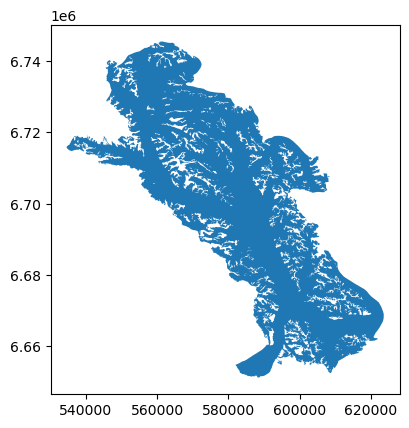

In [37]:
#| hide 

glacier.outline_prj.plot()

In [34]:
#| hide
glacier_pt = Glacier_Point(glacier.name, 'label', glacier.rgi_id, [coords[0][1], coords[0][0]])


original xy [-139.44396972656253, 60.394310536172114] 4326 maps to datacube (-3267683.9170393096, 253957.24542284355) EPSG:3413
subset and load at   3.74 seconds


In [35]:
#| hide
glacier_centerline = Glacier_Centerline(glacier.name, glacier.rgi_id)
                                     

In [39]:
glacier_pt.point_gdf

,x,y,geometry
0,-139.44397,60.394311,POINT (-139.44397 60.39431)
